# Tully-Fisher Relation of galaxies

In [1]:
import os

#from astropy.io import fits
from astropy.table import Table, hstack, join, column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

try:
    import numdifftools as ndt
except ModuleNotFoundError as e:
    ! pip install --user numdifftools
    import numdifftools as ndt
    
from scipy.optimize import minimize, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in targets

In [4]:
sga_table = Table.read('cache/tf_targets_sga.fits')
print(len(np.unique(sga_table['SGA_ID'])))
sga_table[:2]

1403


PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes24
TFT,896,1070144189104132,180.383435473621,1.29623935768054,0,44,180.383498876859,1.29621479718706,0.0222925310315383,2.85320544093656e-05,GALAXY,39.9242557298858,0,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.068

In [5]:
bad_sga_ids = [30149, 474614, 545858, 653059, 811359, 900049, 972260, 1393079]
for bad_sga_id in bad_sga_ids:
    indices = np.where(sga_table['SGA_ID'] == bad_sga_id)
    sga_table.remove_rows(indices)

## Calculate the rotational velocities

And store those at $0.33R_{26}$

Also, remove those with a velocity > 5000 km/s

In [6]:
rmag = []
rmag_err = []
abs_mag = []
abs_mag_err = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(sga_table['SGA_ID'])):
    if sga_id == 474614:
        print('skipped')
        continue
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            d = c * zc / H0 * 1e6 # pc
            d_err = c * zc_err / H0 * 1e6
            m = float(sga_galaxy['R_MAG_SB26'])
            m_err = float(sga_galaxy['R_MAG_SB26_ERR'])
            rmag.append(m)
            rmag_err.append(m_err)
            vmax.append(v033)
            dvmax.append(dv033)
            abs_mag.append(m - 5*np.log10(d/10))
            abs_mag_err.append(np.sqrt(d_err**2 + m_err**2 * 25/d**2))

# cut = [idx for idx in range(len(sga_table)) if sga_table['R_MAG_SB26'][idx] in rmag]
# sga_tab1 = sga_table[cut]
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

/tmp/ipykernel_33838/191502626.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abs_mag = np.asarray(abs_mag)
/tmp/ipykernel_33838/191502626.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abs_mag_err = np.asarray(abs_mag_err)


1170


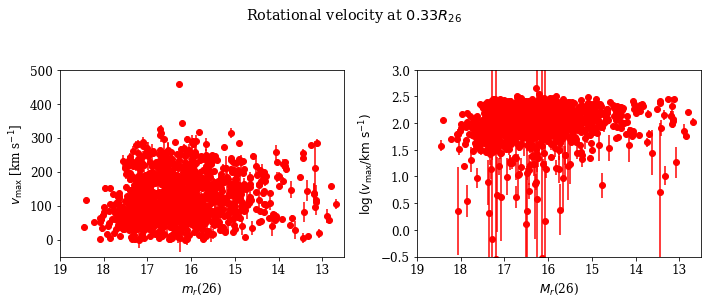

In [7]:
rmag = np.asarray(rmag)
rmag_err = np.asarray(rmag_err)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
abs_mag = np.asarray(abs_mag)
abs_mag_err = np.asarray(abs_mag_err)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(19, 12.5),
       ylim=(-50,500),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26)',
       xlim=(19, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [8]:
rmag = np.asarray(rmag, dtype=float)
vmax = np.asarray(vmax, dtype=float)
dvmax = np.asarray(dvmax, dtype=float)
abs_mag = np.asarray(abs_mag, dtype=float)
abs_mag_err = np.asarray(abs_mag_err, dtype=float)
# abs_mag_err = np.sqrt()

# fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# ax = axes[0]
# ax.errorbar(abs_mag[isrmeas], vmax[isrmeas],yerr=dvmax[isrmeas], fmt='ro')
# ax.set(xlabel='$M_r$(26)',
#        # xlim=(18.5, 12.5),
#        ylim=(-50,500),
#        ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

# ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

# ax.errorbar(abs_mag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
# ax.set(xlabel='$M_r$(26)',
#        # xlim=(18.5, 12.5),
#        ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
#        ylim=(-0.5,3))

# fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

1170


## Cuts on inclination angle and morphology

In [9]:
rmag_clean = []
rmag_err_clean = []
vmax_clean = []
dvmax_clean = []
abs_mag_clean = []
abs_mag_err_clean = []
sga_id_cut = []
pgc_id_cut = []
z = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

sga_table['cosi'] = np.sqrt((sga_table['BA']**2 - q0**2)/(1 - q0**2))
sga_table['cosi'][np.isnan(sga_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

for sga_id in np.unique(sga_table['SGA_ID']):
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        # print('{} cut (morphology)'.format(sga_id))
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        # print('{} cut (inclination)'.format(sga_id))
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)

            d = c * zc / H0 * 1e6 # pc
            d_err = c * zc_err / H0 * 1e6
            m = float(sga_galaxy['R_MAG_SB26'])
            m_err = float(sga_galaxy['R_MAG_SB26_ERR'])
            rmag_clean.append(m)
            rmag_err_clean.append(m_err)
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            abs_mag_clean.append(m - 5*np.log10(d/10))
            abs_mag_err_clean.append(np.sqrt(d_err**2 + m_err**2 * 25/d**2))
            sga_id_cut.append(sga_id)
            # idx = np.where(sga_galaxy['SGA_ID'] == sga_id)[0][0]
            # print(idx)
            # print(sga_galaxy['PGC'])
            pgc = sga_galaxy['PGC']
            if type(pgc) is column.Column:
                pgc = pgc[0]
            # print(type(pgc))
            pgc_id_cut.append(pgc)
            
            # rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            # rmag_err_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            # vmax_clean.append(v033)
            # dvmax_clean.append(dv033)
            # abs_mag_clean.append(float(sga_galaxy['R_MAG_SB26'] - sga_galaxy['DM1_SN']))
            # abs_mag_err_clean.append(np.sqrt((float(sga_galaxy['R_MAG_SB26_ERR']))**2 + (float(sga_galaxy['e_DM1_SN']))**2))
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

/tmp/ipykernel_33838/158645154.py:13: RuntimeWarning: invalid value encountered in sqrt
  sga_table['cosi'] = np.sqrt((sga_table['BA']**2 - q0**2)/(1 - q0**2))


972


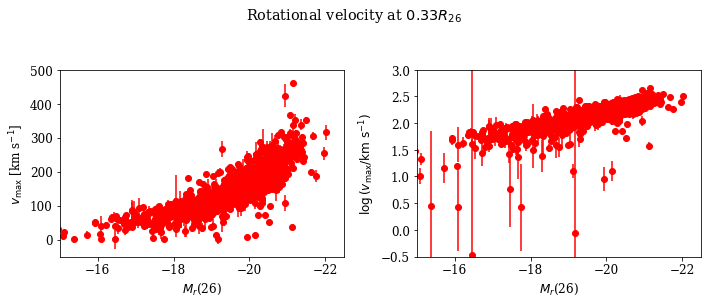

In [10]:
rmag_clean = np.asarray(rmag_clean)
rmag_err_clean = np.asarray(rmag_err_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)
abs_mag_clean = np.asarray(abs_mag_clean)
abs_mag_err_clean = np.asarray(abs_mag_err_clean)

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

isrmeas = rmag_clean > 0.

ax = axes[0]
ax.errorbar(abs_mag_clean[isrmeas], vmax_clean[isrmeas] ,yerr=dvmax_clean[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26)',
       xlim=(-15, -22.5),
       ylim=(-50,500),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

ax.errorbar(abs_mag_clean[isrmeas], log10vmax_clean[isrmeas], yerr=dlog10vmax_clean[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26)',
       xlim=(-15, -22.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

In [ ]:
len(pgc_id_cut)

In [12]:
cuts = [idx for idx in range(len(sga_table)) if sga_table['SGA_ID'][idx] in sga_id_cut]
sga_tab = sga_table[cuts]

In [13]:
sga_tab.write('cache/tf_targets_sga_cuts.fits', format = 'fits', overwrite = True)

OSError: File exists: cache/tf_targets_sga_cuts.fits

In [14]:
tab = Table([sga_id_cut, pgc_id_cut, rmag_clean, rmag_err_clean, vmax_clean, dvmax_clean, log10vmax_clean, dlog10vmax_clean, abs_mag_clean, abs_mag_err_clean],
            names = ['SGA_ID', 'PGC', 'RMAG', 'RMAG_ERR', 'VMAX', 'VMAX_ERR', 'LOG_VMAX', 'LOG_VMAX_ERR', 'ABS_MAG_CALC', 'ABS_MAG_CALC_ERR'])

In [42]:
tab.write('cache/SGA_TF_targets_vmax.fits', format = 'fits')

## Plot TFR

In [4]:
sga_tf = Table.read('cache/SGA_TF_targets_vmax_cleaned.fits', format = 'fits')
sga_tf[:2]

SGA_ID,PGC,RMAG,RMAG_ERR,VMAX,VMAX_ERR,LOG_VMAX,LOG_VMAX_ERR,ABS_MAG_CALC,ABS_MAG_CALC_ERR
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
1548,3502220,17.070053100585938,0.010217264294624329,153.61304846436158,3.6373473993169387,2.186428107852915,0.010276527854141184,-19.281223798701404,23768.12523417303
1583,4006227,17.30707550048828,0.015975113958120346,66.73848646769699,10.953677162903615,1.824376353260026,0.0712317006320059,-17.827886150010855,18785.22950782002


In [5]:
# bad_sga_ids = [30149, 191275, 474614, 900049, 972260, 1124033, 1367749]
# for bad_sga_id in bad_sga_ids:
#     indices = np.where(sga_tf['SGA_ID'] == bad_sga_id)
#     sga_tf.remove_rows(indices)
    
# sga_tf.write('cache/SGA_TF_targets_vmax_cleaned.fits', format = 'fits')

In [6]:
a, b = -0.66674, -0.14654

In [7]:
_a = -a/b
_b = 1/b

In [9]:
_da = 0.09628
_db = 0.86871

-0.66674 -0.14654
-4.549883990719257 -6.824075337791729


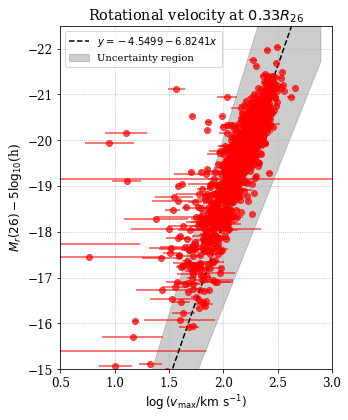

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,6), tight_layout=True)

# rmag_clean = np.asarray(rmag_clean)
# abs_mag_clean = np.asarray(abs_mag_clean)
# vmax_clean = np.asarray(vmax_clean)
# dvmax_clean = np.asarray(dvmax_clean)

# isrmeas_clean = rmag_clean > 0

# log10vmax_clean = np.log10(vmax_clean)
# dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(sga_tf['LOG_VMAX'],
            sga_tf['ABS_MAG_CALC'], 
            # yerr = sga_tf['ABS_MAG_CALC_ERR'],
            xerr = sga_tf['LOG_VMAX_ERR'], 
            fmt='ro', 
            alpha=0.7)


print(a, b)
print(_a, _b)

# ################################################################################


ax.set(ylabel='$M_r(26)-5\log_{10}$(h)',
       ylim=(-15, -22.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')
ax.grid(ls=':')
# r = np.arange(-22.5, -15, 0.1)
logv = np.arange(-0.5, 3, 0.1)
ax.plot(logv, _a + _b*logv, 'k--', label='$y={:9.4f}{:6.4f}x$'.format(_a,_b))

slopes = np.linspace(_b-_db, _b+_db,20) 
intercepts = np.linspace(_a-_da, _a+_da, 20) 
line_array = []
for i in range(len(slopes)):
    line_array.append(logv*slopes[i] + intercepts[i])
line_array = np.asarray(line_array)
lower_edge = np.min(line_array,axis=0)
upper_edge = np.max(line_array,axis=0)
ax.fill_between(logv,lower_edge,upper_edge,color='gray',alpha=0.4, label = 'Uncertainty region')

ax.legend(loc='upper left', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
fig.savefig('tf_SGA_targets_04_15_2022_with_label.png', dpi=120, transparent=True)

# print(np.sum(isrmeas))

## Compute Peculiar Velocities

Let uncertainty in the zero point be $da$ and that in the slope be $db$. Then the uncertainty in TF absolute magnitude is given by:
$$dM=\sqrt{da^2+\left(db\cdot\log{v_{\text{max}}}\right)^2+\left(b\cdot d\log{v_{\text{max}}}\right)^2}$$

In [16]:
## Compute absolute magnitudes from TFR
abs_mag_tf = []
abs_mag_tf_err = []
for logv, dlogv in zip(sga_tf['LOG_VMAX'], sga_tf['LOG_VMAX_ERR']):
    abs_mag_tf.append(_a + _b*logv)
    abs_mag_tf_err.append(np.sqrt(_da**2 + (_db*logv)**2 + (_b*dlogv)**2))

In [17]:
abs_mag_tf[0], abs_mag_tf_err[0]

(-19.470234119372968, 1.9031031488551746)

In [27]:
## Extract observed redshift and compute peculiar redshift
z_obs = []
dz_obs = []
z_H = []
dz_H = []
z_p = []
dz_p = []
bad_id = []

for i in range(len(sga_tf['SGA_ID'])):
    
    sga_id = sga_tf['SGA_ID'][i]
    M_obs, dM_obs = sga_tf['ABS_MAG_CALC'][i], sga_tf['ABS_MAG_CALC_ERR'][i] 
    M_TF, dM_TF = abs_mag_tf[i], abs_mag_tf_err[i] 
    
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    z_obs.append(zc)
    dz_obs.append(zc_err)
    # print(zc)
    if np.shape(sga_galaxy['R_MAG_SB26']) == (0,):
        bad_id.append(sga_id)
        continue
    m, m_err = float(sga_galaxy['R_MAG_SB26']), float(sga_galaxy['R_MAG_SB26_ERR'])
    zH = zc * 10**((M_obs-M_TF)/5)
    dzH = np.sqrt(zc_err**2 * 10**(2*(M_obs-M_TF)/5) + (zc*np.log(10)/5)**2 * (dM_obs**2 * 10**(2*M_obs/5)+dM_TF**2 * 10**(2*M_TF/5)))
    z_H.append(zH)
    dz_H.append(dzH)
    z_p.append(((1+zc)/(1+zH)) - 1)
    dz_p.append(np.sqrt(((1+zc)/(1+zH)**2 * dzH)**2 + (zc_err/(1+zH))**2))

In [28]:
sga_tf['Z_OBS'] = z_obs
sga_tf['Z_OBS_ERR'] = dz_obs
sga_tf['Z_H'] = z_H
sga_tf['Z_H_ERR'] = dz_H
sga_tf['Z_P'] = z_p
sga_tf['Z_P_ERR'] = dz_p

In [30]:
sga_tf['ABS_MAG_TF'] = abs_mag_tf
sga_tf['ABS_MAG_TF_ERR'] = abs_mag_tf_err

In [31]:
sga_tf.write('cache/SGA_PV.fits', format = 'fits', overwrite = True)

In [12]:
sga_tf = Table.read('cache/SGA_PV.fits', format = 'fits')
sga_tf.columns

<TableColumns names=('SGA_ID','PGC','RMAG','RMAG_ERR','VMAX','VMAX_ERR','LOG_VMAX','LOG_VMAX_ERR','ABS_MAG_CALC','ABS_MAG_CALC_ERR','Z_OBS','Z_OBS_ERR','Z_H','Z_H_ERR','Z_P','Z_P_ERR','ABS_MAG_TF','ABS_MAG_TF_ERR')>

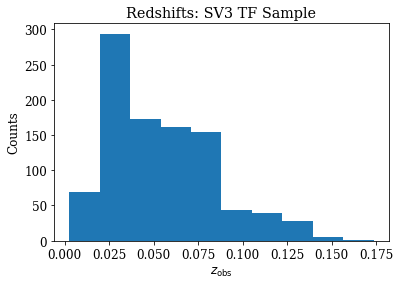

In [20]:
plt.hist(sga_tf['Z_OBS'])
plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel('Counts')
plt.title('Redshifts: SV3 TF Sample')
# plt.axvline(0.05, color = 'k', ls = ':')
# plt.show()
plt.savefig('z_obs_hist_SV3.png', dpi=120, transparent=True)